# **Extract data through Google API**

In [136]:
import os
from typing import List, Dict, Any, Tuple
import json
import pandas as pd
import geopandas as gpd
import requests
import pprint
import datetime
import matplotlib.pyplot as plt

##### **Steps**:
To get the data from the Google Bucket into workable format, we follow:
* Connect with the API
* **Expand this step!** Set-up pipeline which downloads all relevant data per country code
* Format the data into DateTime (y) and features (x)
* Store externally as .csv

##### **Background info -- API**
The API has three basic functions:
* *ListGauges*: Returns a list of supported gauges within a given country (code)
* *GetGaugeModel*: Returns model information of a specific gauge (within a given country, that is)
* *QueryGaugeForecasts*: Returns the forecasts of specific gauge

In [137]:
def get_API_key(path : str) -> str:
    """
    Get the API key from a .txt file stored elsewhere

    :param path: path to the .txt file containing the API key
    :return: the API key
    """
    with open(path, 'r') as f:
        return f.read().strip()

# Note: add this folder manually at the pointed path for the script to run
# For the key, ask the owner of the repository or try brute force :)
path_API_key = "../../data/keys/API_key.txt"

In [138]:
def get_country_codes(path : str) -> Dict:
    """
    Get the country codes from a .json file stored elsewhere

    :param path: path to the .json file containing the country codes
    :return: the country codes
    """
    with open(path, 'r') as f:
        return json.load(f)


path_country_codes = "../../data/country_codes.json"
dict_country_codes = get_country_codes(path_country_codes)

In [139]:
def generate_url_ListGauges(path_to_key : str) -> str:
    """
    Generate the URL to get the list of gauges for a specific country

    :param path_to_key: path to the .txt file containing the API key
    :return: the URL
    """
    base_url = 'https://floodforecasting.googleapis.com/v1/gauges:searchGaugesByArea'
    return f'{base_url}?key={get_API_key(path_to_key)}'

In [140]:
def make_request_ListGauges(country_code : str, path_to_key : str) -> List[Dict[str, Any]]:
    """
    Make the API request for the list of gauges for a specific country

    :param url: the URL
    :return: the list of gauges
    """
    response = requests.post(
        generate_url_ListGauges(path_to_key),
        json = {'regionCode': country_code}
    )
    
    return response


def verify_ListGauges(response : Any) -> List[Dict[str, Any]]:
    """
    Get the list of gauges for a specific country, and verify the response

    :param country_code: the country code
    :param path_to_key: path to the .txt file containing the API key
    :return: the list of gauges
    """
    if response.status_code != 200:
        raise Exception(f'Error: {response.status_code} -- {response.text}')

    try:
        return response.json()['gauges']
    except ValueError as exc:
        raise Exception(f'Error parsing .json: {exc} -- {response.text}')
    

def convert_ListGauges_to_df(gauges : List[Dict[str, Any]]) -> pd.DataFrame:
    """
    Convert the list of gauges to a pd.DataFrame

    :param gauges: the list of gauges
    :return: the DataFrame
    """
    df = pd.DataFrame(gauges)
    df['latitude'] = df['location'].apply(lambda x: x['latitude'])
    df['longitude'] = df['location'].apply(lambda x: x['longitude'])
    df.drop(columns = ['location'], inplace = True)
    return df


def get_ListGauges(country_code : str, path_to_key : str) -> pd.DataFrame:
    """
    Get the list of gauges for a specific country by calling helper functions which:
    - generate the URL;
    - make the request;
    - verify the response; and
    - convert to a pd.DataFrame in the end.

    :param country_code: the country code
    :param path_to_key: path to the .txt file containing the API key
    :return: DataFrame with the gauges
    """
    return convert_ListGauges_to_df(
        verify_ListGauges(
            make_request_ListGauges(
                country_code, path_to_key
            )
        )
    )

In [141]:
def print_gauges(gauges : List[Dict[str, Any]]) -> None:
    """
    Print the list of gauges

    :param gauges: the list of gauges
    """
    for gauge in gauges:
        print(f"{gauge['siteName']} ({gauge['gaugeId']})")

In [142]:
df_gauges_ML = get_ListGauges('ML', path_API_key)

In [143]:
print(type(df_gauges_ML))
print(len(df_gauges_ML))
print(df_gauges_ML.columns)


<class 'pandas.core.frame.DataFrame'>
16
Index(['siteName', 'source', 'river', 'gaugeId', 'qualityVerified', 'latitude',
       'longitude'],
      dtype='object')


In [144]:
print(df_gauges_ML.head(2))

  siteName source river           gaugeId  qualityVerified   latitude  \
0           HYBAS        hybas_1120739110             True  11.977083   
1           HYBAS        hybas_1120679780             True  13.493750   

   longitude  
0  -6.360417  
1  -6.202083  


In [148]:
def convert_df_to_gdf(df : pd.DataFrame) -> gpd.GeoDataFrame:
    """
    Convert a DataFrame to a GeoDataFrame by taking the latitude and longitude columns

    :param df: the DataFrame
    :return: the GeoDataFrame
    """
    return gpd.GeoDataFrame(
        df,
        geometry = gpd.points_from_xy(df['longitude'], df['latitude']),
        crs = 'EPSG:4326' # Uniform projection to WGS84
    )


def map_gauge_coordinates_of_country(df : pd.DataFrame, country : str) -> None:
    """
    Map gauge coordinates

    :param df: the DataFrame with the gauges
    :return: the GeoDataFrame
    """
    gdf = convert_df_to_gdf(df)

    # try:
    #     shape = gpd.read_file(f"../../data/shape_files/{country}_country_bounds.shp")
    # except Exception as exc:
    #     raise Exception(f'Error reading shape file: {exc}')

    fig, ax = plt.subplots()
    # shape.plot(ax = ax, color = 'lightgrey')
    gdf.plot(ax = ax, color = 'red', markersize = 10)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Gauge locations for {country}')
    ax.set_aspect('equal') # Ensure unwarped aspect ratio
    plt.show()

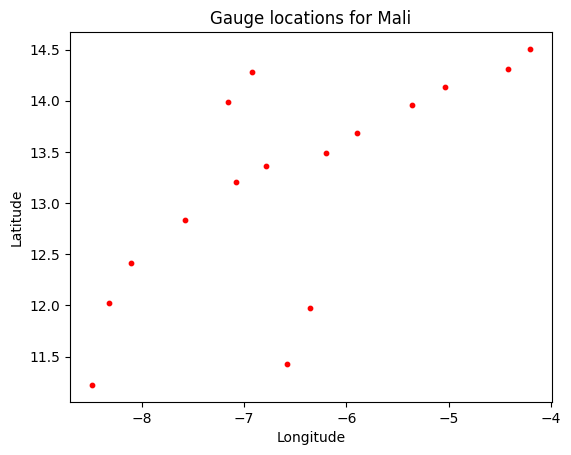

In [149]:
map_gauge_coordinates_of_country(df_gauges_ML, 'Mali')

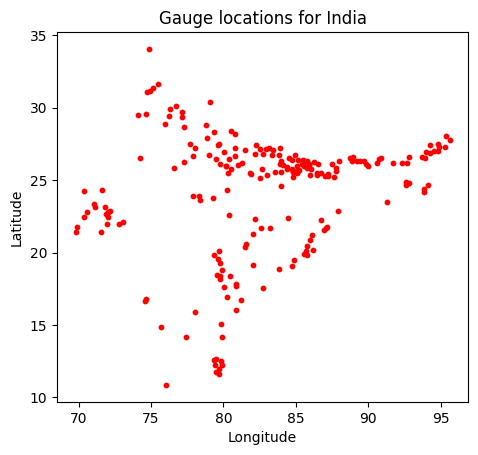

In [152]:
map_gauge_coordinates_of_country(get_ListGauges('IN', path_API_key), 'India')